In [1]:
import numpy as np
import scipy
import cv2
from matplotlib import pyplot as plt
from douglas_rachford import DRSolver
from skimage import data, color

## Starting image:

In [2]:
img = color.rgb2gray(data.astronaut() / 255.0) 

## Base PSF generators

In [3]:
def get_gaussian_psf(k_size, std):
    gaussian_1d = scipy.signal.windows.gaussian(k_size, std).reshape(k_size, 1)
    gaussian_kernel = gaussian_1d @ gaussian_1d.T
    gaussian_kernel /= np.sum(gaussian_kernel)

    return gaussian_kernel

def get_box_psf(k_size):
    return np.ones((k_size, k_size))/ (k_size**2)

def get_circle_psf(k_size):
    radius = k_size//2
    y, x = np.ogrid[-radius:radius+1, -radius:radius+1]
    mask = x*x + y*y <= radius*radius
    circle = np.zeros((k_size, k_size))
    circle[mask] = 1.0
    return circle / np.sum(circle)

## Spacially-Variyng PSFs:

In [4]:
from psf_utils import *

k_size = 15
grid_size = (5,5)

random_gaussian_psfs, random_gaussian_weights = random_gaussian_grid(k_size, grid_size, img.shape, std_min=0.01, std_max=5) 
radial_gaussian_psfs, radial_gaussian_weights = radial_gaussian_grid(k_size, grid_size, img.shape, std=1.1)

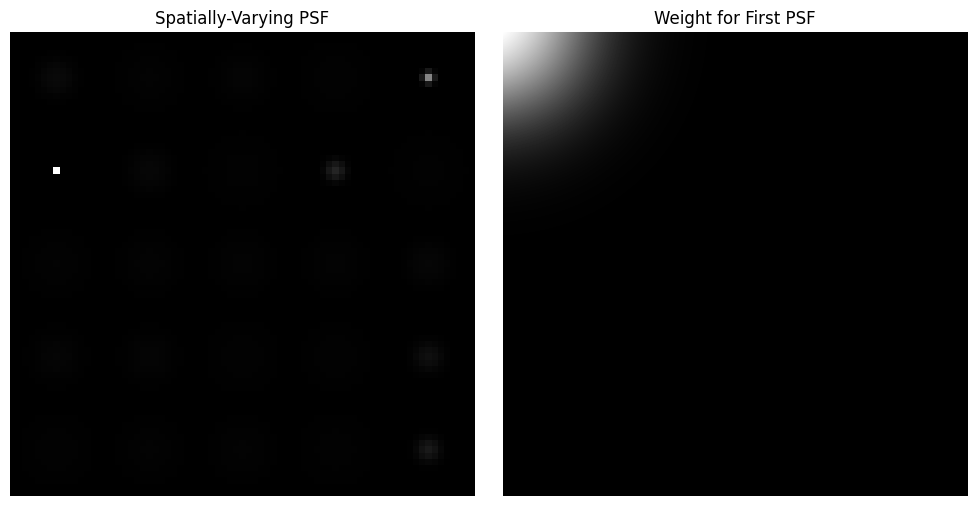

In [5]:
visualize_psf_grid(random_gaussian_psfs, random_gaussian_weights)

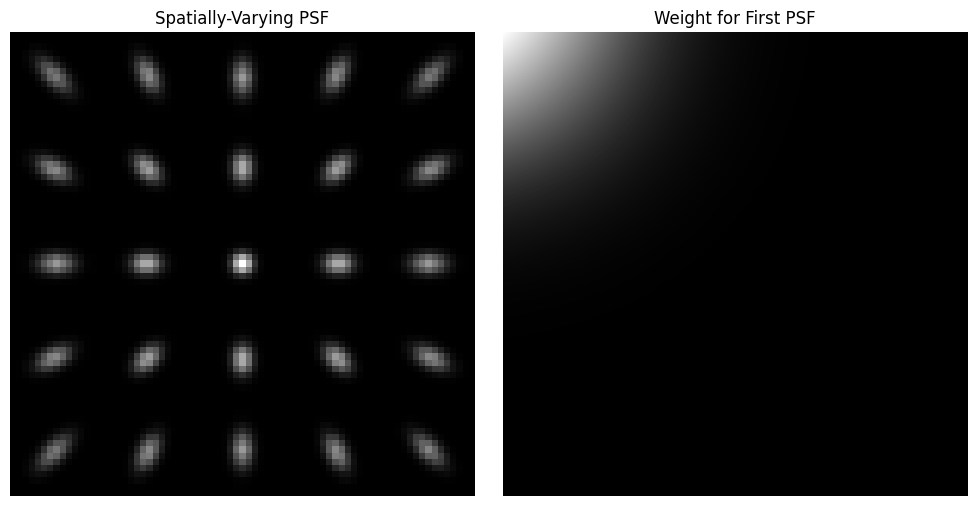

In [15]:
visualize_psf_grid(radial_gaussian_psfs, radial_gaussian_weights)

## Blur images with Spatial PSF and add some noise:

In [7]:
random_blurred = apply_spatial_psf(img, random_gaussian_psfs, random_gaussian_weights)
radial_blurred = apply_spatial_psf(img, radial_gaussian_psfs, radial_gaussian_weights)

noise = 0.03 * np.random.randn(img.shape[0], img.shape[1])

random_blurred += noise
radial_blurred += noise

(-0.5, 511.5, 511.5, -0.5)

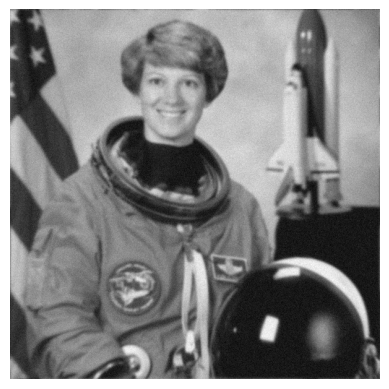

In [17]:
plt.imshow(radial_blurred,cmap='gray')
plt.axis('off')

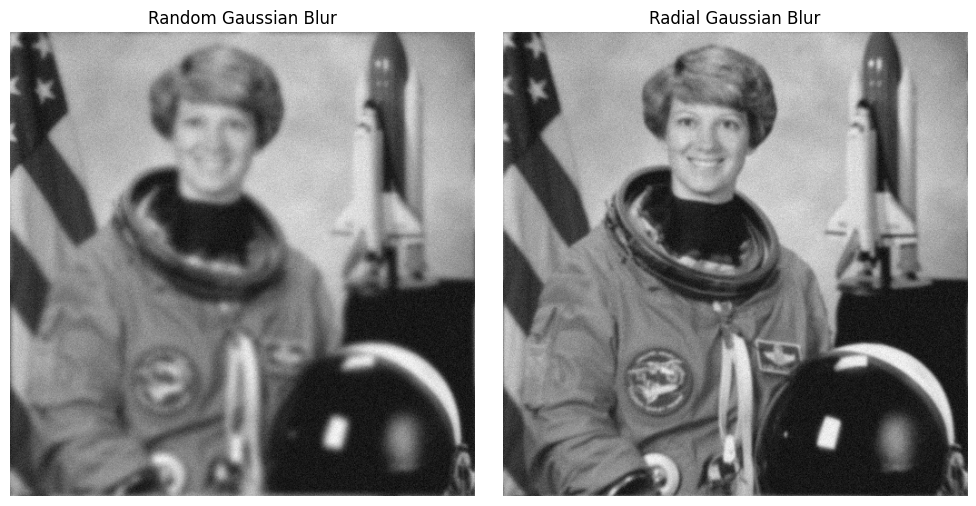

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.imshow(random_blurred, cmap='gray')
ax1.set_title('Random Gaussian Blur')
ax1.axis('off')

ax2.imshow(radial_blurred, cmap='gray')
ax2.set_title('Radial Gaussian Blur') 
ax2.axis('off')

plt.tight_layout()
plt.show()

## Broken Phone camera simulation: Random PSF distribution

In [9]:
# The image and kernel information
# b = random_blurred 
# K = random_gaussian_psfs
# U = random_gaussian_weights
b = radial_blurred 
K = radial_gaussian_psfs
U = radial_gaussian_weights

# Optimization hyperparameters
lmda = 0.05
beta = 1.0
tau = 0.1
over_relax = 1

# logging losses
log = True

solver = DRSolver(b, K, U, lmda, beta, tau, over_relax, log, img_og=img)

In [10]:
deblurred = solver.solve(n_iters = 100)

  0%|          | 0/100 [00:00<?, ?it/s]/Users/felipemautner/Library/CloudStorage/GoogleDrive-fmautner@andrew.cmu.edu/My Drive/CMU/F24/15-463/463-final-project/src/douglas_rachford.py:150: RuntimeWarning: divide by zero encountered in divide
  scale = np.minimum(1, 1/norm)
100%|██████████| 100/100 [04:12<00:00,  2.52s/it]


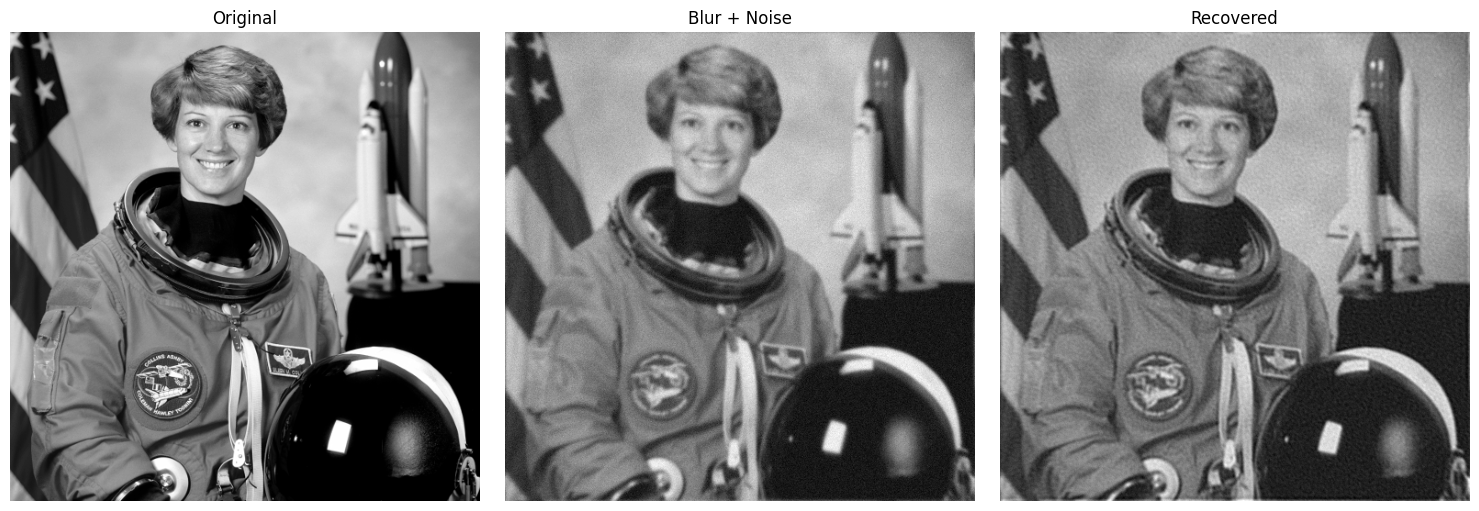

In [18]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

ax1.imshow(img, cmap='gray')
ax1.set_title('Original')
ax1.axis('off')

ax2.imshow(radial_blurred, cmap='gray')
ax2.set_title('Blur + Noise')
ax2.axis('off')

ax3.imshow(deblurred, cmap='gray')
ax3.set_title('Recovered')
ax3.axis('off')

plt.tight_layout()
plt.show()

## Cost over iterations

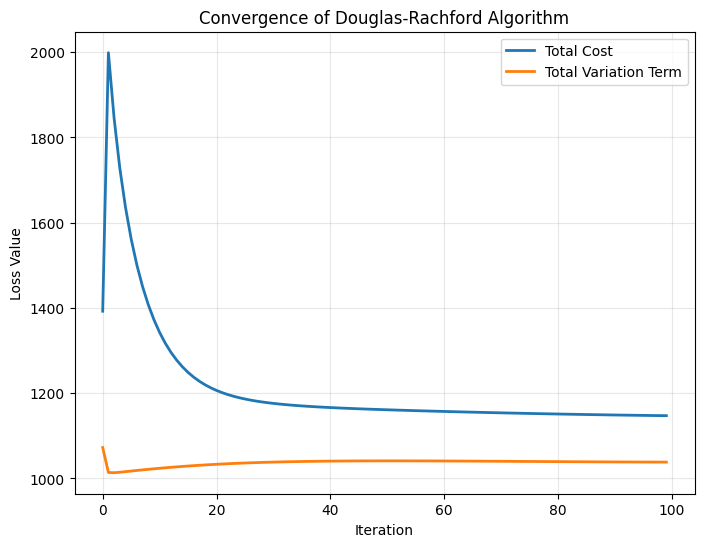

In [12]:
plt.figure(figsize=(8, 6))
plt.plot(solver.losses['cost'], label='Total Cost', linewidth=2)
plt.plot(solver.losses['TV'], label='Total Variation Term', linewidth=2)
plt.xlabel('Iteration')
plt.ylabel('Loss Value')
plt.title('Convergence of Douglas-Rachford Algorithm')
plt.grid(True, alpha=0.3)
plt.legend(frameon=True, loc='upper right')